<a href="https://colab.research.google.com/github/ortall0201/Spotify-Playlist-Recommender-System-Using-NLP/blob/main/Manor/Triplet_Formation%2C_Model_building%2C_Implementation_and_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating train and test sets, with song_mames divided proportionally
This step ensures that the dataset is split into train and test sets in a way that maintains proportional representation of songs across both sets. The goal is to enable a robust evaluation of the model's performance while preserving data consistency.
* Proportional Split by Song:

>>>> Each unique song (song_name) is considered a group.

* Within each group:
>>>If the song appears in only one row, it is assigned entirely to the train set.
>>>Otherwise, the group is split proportionally into train and test sets using an 80-20 split.

In [ ]:
# call preprocessed data

csv_file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/cleaned_step4.csv'
playlists_df = pd.read_csv(csv_file_path)

In [ ]:
playlists_df.head()

,user_id,artist_name,track_name,playlist_name,song_name,unq_playlist_name,track_word_count
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,(the angels wanna wear my) red shoes,hard rock 2010,elvis costello - (the angels wanna wear my) re...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,7
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,"(what's so funny 'bout) peace, love and unders...",hard rock 2010,elvis costello & the attractions - (what's so ...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,8
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,hard rock 2010,tiffany page - 7 years too late,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,4
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello & the attractions,accidents will happen,hard rock 2010,elvis costello & the attractions - accidents w...,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,3
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,hard rock 2010,elvis costello - alison,9cc0cfd4d7d7885102480dd99e7a90d6 - hard rock 2010,1


In [ ]:
playlists_df.shape

(8827807, 7)

In [ ]:
playlists_df.columns

Index(['user_id', 'artist_name', 'track_name', 'playlist_name', 'song_name',
       'unq_playlist_name', 'track_word_count'],
      dtype='object')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def proportional_split(df, song_column, test_size=0.2, random_state=42):

    train_data = []
    test_data = []

    # Group by the song column
    grouped = df.groupby(song_column)

    for _, group in grouped:
        if len(group) == 1:
            # If only one row, assign it to the train set
            train_data.append(group)
        else:
            # Split the group proportionally
            train_group, test_group = train_test_split(
                group,
                test_size=test_size,
                random_state=random_state
            )
            train_data.append(train_group)
            test_data.append(test_group)

    # Combine all train and test groups
    train_df = pd.concat(train_data).reset_index(drop=True)
    test_df = pd.concat(test_data).reset_index(drop=True)

    return train_df, test_df



In [ ]:
train_df, test_df = proportional_split(playlists_df, song_column='song_name', test_size=0.2)


In [ ]:
train_df.shape

(6918549, 7)

In [ ]:
test_df.shape

(1909258, 7)

In [ ]:
train_df.to_csv('/content/drive/My Drive/Colab Notebooks/Final Project/playlists_train_df.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/Final Project/playlists_test_df.csv', index=False)

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Final Project/playlists_train_df.csv'
playlists_df = pd.read_csv(path) # assign playlists_df as the train set

In [42]:
import pandas as pd

path = '/content/drive/My Drive/Colab Notebooks/Final Project/playlists_test_df.csv'
test_data = pd.read_csv(path) # assign playlists_df as the train set

In [ ]:
# Number of unique artists

playlists_df['artist_name'].nunique()
print(f"Number of unique artists: {playlists_df['artist_name'].nunique()}")

# Number of unique users

unique_users = playlists_df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

# Number of unique songs

unique_songs = playlists_df['song_name'].nunique()
print(f"Number of unique songs: {unique_songs}")

# Number of playlists

unique_playlists = playlists_df['unq_playlist_name'].nunique()
print(f"Number of playlists: {unique_playlists}")

# Average songs per playlist

average_songs_per_playlist = playlists_df.groupby('unq_playlist_name')['song_name'].nunique().mean()
print(f"Average songs per playlist: {average_songs_per_playlist:.2f}")

Number of unique artists: 223712
Number of unique users: 15345
Number of unique songs: 1913703
Number of playlists: 213685
Average songs per playlist: 32.38


# Triplets generation
This section focuses on triplet generation for training a Siamese network. The triplets consist of an anchor, a positive, and a negative, designed to teach the model the semantic relationships between songs. The process includes balancing easy and hard negatives, ensuring diverse and challenging training examples.

Logic Behind Triplet Generation
Triplet Structure:

* Anchor: A song from a playlist.
* Positive: Another song from the same playlist (semantically similar).
* Negative: A song that is either:
** Easy Negative: Randomly sampled from a global pool of unrelated songs.
** Hard Negative: Sampled from playlists overlapping with the anchor playlist (closer in semantic space).
* Balanced Negatives:
** Controls the proportion of hard negatives in the triplets (e.g., 50% using hard_negative_ratio).
* Efficient Sampling:
** Rotating Global Pool: Changes every 100 playlists to maintain diversity.
** Parallel Processing: Utilizes multiprocessing for faster computation of negatives.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, Manager, Process


def update_progress_bar(queue, total):
    """Updates a progress bar for multiprocessing tasks."""
    pbar = tqdm(total=total, desc="Processing Playlists")
    while True:
        pbar.update(queue.get())
        if pbar.n >= total:
            break
    pbar.close()


def compute_negatives_with_rotating_pool(args):
    """
    Computes negatives for a chunk of playlists using a rotating global pool.

    Args:
    - args: Tuple containing (playlist_chunk, global_negative_pool, negative_pool_size, overlap_index, progress_queue).

    Returns:
    - result: Dictionary of playlist_id -> dict with 'easy_negatives' and 'hard_negatives'.
    """
    playlist_chunk, global_negative_pool, negative_pool_size, overlap_index, progress_queue = args
    result = {}

    for playlist_id, playlist_songs in playlist_chunk.items():
        # Easy negatives: from the global pool, excluding playlist songs
        easy_neg_candidates = set(global_negative_pool) - set(playlist_songs)
        if easy_neg_candidates:
            easy_negatives = np.random.choice(
                list(easy_neg_candidates),
                size=min(negative_pool_size, len(easy_neg_candidates)),
                replace=False
            ).tolist()
        else:
            easy_negatives = []

        # Hard negatives: from overlapping playlists
        hard_neg_candidates = set()
        for song in playlist_songs:
            if song in overlap_index:
                for other_playlist_id in overlap_index[song]:
                    if other_playlist_id != playlist_id:
                        hard_neg_candidates.update(playlists[other_playlist_id])
        hard_neg_candidates -= set(playlist_songs)

        if hard_neg_candidates:
            hard_negatives = np.random.choice(
                list(hard_neg_candidates),
                size=min(negative_pool_size, len(hard_neg_candidates)),
                replace=False
            ).tolist()
        else:
            hard_negatives = []

        result[playlist_id] = {'easy_negatives': easy_negatives, 'hard_negatives': hard_negatives}
        progress_queue.put(1)

    return result


def parallel_playlist_negatives_with_rotating_pool(playlists, all_songs, global_pool_size, negative_pool_size, num_workers=8):
    """
    Parallelized computation of negatives (easy and hard) for all playlists using rotating global pools.

    Args:
    - playlists: Dictionary of playlist_id -> list of songs.
    - all_songs: Set of all unique songs.
    - global_pool_size: Number of songs in the global negative pool.
    - negative_pool_size: Maximum number of negative candidates per playlist.
    - num_workers: Number of parallel workers.

    Returns:
    - combined_results: Dictionary of playlist_id -> dict with 'easy_negatives' and 'hard_negatives'.
    """
    # Build an overlap index for hard negatives
    overlap_index = {}
    for playlist_id, songs in playlists.items():
        for song in songs:
            if song not in overlap_index:
                overlap_index[song] = []
            overlap_index[song].append(playlist_id)

    # Convert all_songs to a list for easy sampling
    all_songs = list(all_songs)

    # Split playlists into chunks for rotating pools
    playlist_ids = list(playlists.keys())
    chunks = np.array_split(playlist_ids, len(playlist_ids) // 100)

    combined_results = {}
    manager = Manager()
    progress_queue = manager.Queue()

    # Start a process to update the progress bar
    progress_process = Process(target=update_progress_bar, args=(progress_queue, len(playlist_ids)))
    progress_process.start()

    for chunk in tqdm(chunks, desc="Rotating Pools"):
        # Generate a new global pool for this chunk
        global_negative_pool = np.random.choice(all_songs, size=global_pool_size, replace=False)

        # Split the chunk for parallel processing
        chunk_playlists = {pid: playlists[pid] for pid in chunk}
        sub_chunks = np.array_split(list(chunk_playlists.keys()), num_workers)
        sub_chunks = [{pid: chunk_playlists[pid] for pid in sub_chunk} for sub_chunk in sub_chunks]

        # Use multiprocessing to compute negatives for each sub-chunk
        with Pool(num_workers) as pool:
            results = pool.map(
                compute_negatives_with_rotating_pool,
                [(sub_chunk, global_negative_pool, negative_pool_size, overlap_index, progress_queue) for sub_chunk in sub_chunks]
            )

        # Combine results from all sub-chunks
        for result in results:
            combined_results.update(result)

    # Close the progress bar
    progress_process.terminate()

    return combined_results


def generate_triplets(playlists, playlist_negatives, num_triplets, hard_negative_ratio=0.5, seed=42):
    """
    Generates triplets (anchor, positive, negative) with balanced easy and hard negatives.

    Args:
    - playlists: Dictionary of playlist_id -> list of songs.
    - playlist_negatives: Dictionary of playlist_id -> dict with 'easy_negatives' and 'hard_negatives'.
    - num_triplets: Total number of triplets to generate.
    - hard_negative_ratio: Ratio of triplets using hard negatives (0.0 to 1.0).
    - seed: Random seed for reproducibility.

    Returns:
    - triplets: A list of unique triplets (anchor, positive, negative).
    """
    np.random.seed(seed)
    triplets = set()

    print(f"Generating {num_triplets} triplets with {hard_negative_ratio*100}% hard negatives...")
    pbar = tqdm(total=num_triplets, desc="Triplet Generation")

    while len(triplets) < num_triplets:
        # Randomly select a playlist
        playlist_id = np.random.choice(list(playlists.keys()))
        playlist_songs = playlists[playlist_id]

        # Skip playlists with fewer than 2 songs
        if len(playlist_songs) < 2:
            continue

        # Randomly sample anchor and positive
        anchor, positive = np.random.choice(playlist_songs, size=2, replace=False)

        # Decide between easy or hard negative
        use_hard_negative = np.random.rand() < hard_negative_ratio
        negative_pool = playlist_negatives[playlist_id]['hard_negatives'] if use_hard_negative else playlist_negatives[playlist_id]['easy_negatives']

        if not negative_pool:
            continue

        negative = np.random.choice(negative_pool)
        triplets.add((anchor, positive, negative))
        pbar.update(1)

    pbar.close()
    print(f"Generated {len(triplets)} triplets.")
    return triplets



# Group songs by playlist
playlists = playlists_df.groupby('unq_playlist_name')['song_name'].apply(list).to_dict()
all_songs = set(playlists_df['song_name'])

# Parameters
global_pool_size = int(0.025 * len(all_songs))  # 2.5% of all songs for the global pool
negative_pool_size = 4000                     # Number of negatives per playlist
num_workers = 4                               # Number of parallel workers
num_triplets = 30000000                         # Total number of triplets to generate
hard_negative_ratio = 0.5                     # Ratio of triplets with hard negatives

# Step 1: Compute Negatives with Easy and Hard Pools
print("Computing playlist negatives (easy and hard) with rotating pools...")
playlist_negatives = parallel_playlist_negatives_with_rotating_pool(
    playlists, all_songs, global_pool_size, negative_pool_size, num_workers
)

# Step 2: Generate Balanced Triplets
print("Generating triplets with balanced easy and hard negatives...")
triplets = generate_triplets(playlists, playlist_negatives, num_triplets, hard_negative_ratio=hard_negative_ratio)

# Output Results
print(f"Generated {len(triplets)} triplets:")
for triplet in list(triplets)[:5]:
    print(triplet)


Computing playlist negatives (easy and hard) with rotating pools...


Processing Playlists:  28%|██▊       | 59161/213685 [6:59:09<9:51:40,  4.35it/s] 

In [ ]:
# save triplets as df for safe keeping
triplets_df = pd.DataFrame(list(triplets), columns=['anchor', 'positive', 'negative'])
output_csv_path = '/content/drive/My Drive/Colab Notebooks/Final Project/train_triplets_new.csv'
triplets_df.to_csv(output_csv_path, index=False)



In [ ]:
triplets_df.shape

(19197170, 3)

In [ ]:
triplets_df.isna().sum()

,0
anchor,0
positive,0
negative,0


In [ ]:
unique_counts = {col: triplets_df[col].nunique() for col in triplets_df.columns}
unique_counts

{'anchor': 1383531, 'positive': 1383643, 'negative': 1907442}

In [ ]:
triplets_df.duplicated().sum()

0

In [ ]:
# call triplets back to set - mount drive (1)

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# call triplets back to set - call data (2)
import pandas as pd

csv_file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/all_triplets_combined.csv'
triplets_df = pd.read_csv(csv_file_path)
triplets = set(triplets_df.itertuples(index=False, name=None))

In [ ]:
del triplets_df

import gc

gc.collect()

0

In [ ]:
triplets_df.head()

,anchor,positive,negative
0,nationalteatern - spisa,nationalteatern - kolla kolla,brian tyler - letty's cell phone
1,pitbull - timber,calvin harris - summer,afrika bambaataa feat. muriel fowler - touch & go
2,mgmt - astro-mancy,mgmt - it's working,the revolutionaries - thank the lord version
3,creedence clearwater revival - someday never c...,creedence clearwater revival - midnight special,coldplay - politik - live in sydney
4,air - j'ai dormi sous l'eau,ensemble du verre - annalizer (bugge wesseltof...,maverick sabre - track by track: a change is g...


In [ ]:
triplets_df.shape

(19197170, 3)

# Analysis and integrity check for triplets
This section ensures the integrity and balance of the generated triplets. By analyzing the frequency and distribution of anchors, positives, and negatives, we can validate whether the triplets meet the criteria for training a robust Siamese network.

In [ ]:
# Anchor Song Analysis
# Objective: Ensure that all songs have a chance to appear as an anchor and identify any missing songs.

from collections import Counter

# Count how often each song appears as an anchor
anchors = [triplet[0] for triplet in triplets]
anchor_counts = Counter(anchors)

# Compare with the original dataset
all_songs = set(playlists_df['song_name'])
missing_songs = all_songs - set(anchors)

print(f"Number of unique anchors: {len(set(anchors))}")
print(f"Songs missing as anchors: {len(missing_songs)}")
print(f"Most common anchors: {anchor_counts.most_common(5)}")


Number of unique anchors: 1383531
Songs missing as anchors: 530172
Most common anchors: [('lorde - royals', 5270), ('imagine dragons - radioactive', 5255), ('avicii - wake me up', 5144), ('daft punk - get lucky - radio edit', 5011), ('daft punk - get lucky', 4909)]


In [ ]:
# Balance triplet anchors
# Goal: Avoid over-representation of dominant anchors.
# Method:
# For anchors with more than 100 triplets, randomly sample up to 100 triplets.
# Retain all triplets for non-dominant anchors.

from collections import Counter
import random

# Count occurrences of each anchor
anchor_counts = Counter([triplet[0] for triplet in triplets])

# Group triplets by anchor
anchor_to_triplets = {}
for triplet in triplets:
    anchor = triplet[0]
    if anchor not in anchor_to_triplets:
        anchor_to_triplets[anchor] = []
    anchor_to_triplets[anchor].append(triplet)

# Downsample triplets for dominant anchors
balanced_triplets = []
for anchor, triplet_list in anchor_to_triplets.items():
    if len(triplet_list) > 100:
        # Randomly sample to limit the number of triplets
        balanced_triplets.extend(random.sample(triplet_list, 100))
    else:
        # Keep all triplets for non-dominant anchors
        balanced_triplets.extend(triplet_list)

triplets = balanced_triplets



In [ ]:
from collections import Counter

# Count how often each song appears as an anchor after anchor balancing
anchors = [triplet[0] for triplet in triplets]
anchor_counts = Counter(anchors)

# Compare with the original dataset
all_songs = set(playlists_df['song_name'])
missing_songs = all_songs - set(anchors)

print(f"Number of unique anchors: {len(set(anchors))}")
print(f"Songs missing as anchors: {len(missing_songs)}")
print(f"Most common anchors: {anchor_counts.most_common(5)}")


Number of unique anchors: 1383531
Songs missing as anchors: 530172
Most common anchors: [('bruno mars - the lazy song', 100), ('kavinsky - nightcall', 100), ('the smashing pumpkins - 1979', 100), ('lou reed - walk on the wild side - remastered', 100), ('metric - gimme sympathy', 100)]


In [ ]:
# Positive Pair Analysis
# Objective: Analyze the distribution of positive pairs (anchor, positive) to ensure diversity.
# Key Metrics:
# Unique Positive Pairs: Number of unique anchor-positive pairs.
# Dominant Positive Pairs: Most frequently occurring pairs.

positive_pairs = [(triplet[0], triplet[1]) for triplet in triplets]
positive_pair_counts = Counter(positive_pairs)

print(f"Number of unique positive pairs: {len(set(positive_pairs))}")
print(f"Most common positive pairs: {positive_pair_counts.most_common(5)}")


Number of unique positive pairs: 9224944
Most common positive pairs: [(('fuel fandango - new life - pablo fierro & ale acosta rmx', 'fuel fandango - new life'), 100), (('merche - dos amigos', 'merche - te espero cada noche'), 100), (('pale seas - evil is always one step behind', 'pale seas - wicked dreams'), 100), (('the classic city collective - no greater love', 'the classic city collective - at your feet'), 100), (("nwa - don't buy a poppy", 'arctic monkeys - r u mine?'), 100)]


In [ ]:
# Negative Song Analysis
# Objective: Validate the diversity of negative samples.
# Key Metrics:
# Unique Negatives: Number of unique songs used as negatives.
# Dominant Negatives: Most frequently used songs as negatives.

negatives = [triplet[2] for triplet in triplets]
negative_counts = Counter(negatives)

print(f"Number of unique negatives: {len(set(negatives))}")
print(f"Most common negatives: {negative_counts.most_common(5)}")


Number of unique negatives: 1892473
Most common negatives: [('daft punk - get lucky - radio edit', 583), ('m83 - midnight city', 581), ('imagine dragons - radioactive', 564), ('lorde - royals', 529), ('capital cities - safe and sound', 524)]


In [ ]:
# Playlist Coverage
# Goal: Verify that the generated triplets cover a significant portion of playlists.
# Key Metrics:
# Total Playlists: Number of playlists in the dataset.
# Playlists in Triplets: Number of playlists contributing to triplets.

# Count how many playlists contribute to triplets
playlist_ids_in_triplets = set(playlists_df[playlists_df['song_name'].isin(anchors)]['unq_playlist_name'])

print(f"Number of playlists in dataset: {playlists_df['unq_playlist_name'].nunique()}")
print(f"Number of playlists in triplets: {len(playlist_ids_in_triplets)}")


Number of playlists in dataset: 214394
Number of playlists in triplets: 214382


In [ ]:
# Unique vs. Total Triplets

print(f"Total triplets: {len(triplets)}")
print(f"Unique triplets: {len(set(triplets))}")
print(f"Proportion of unique triplets: {len(set(triplets)) / len(triplets):.2f}")


Total triplets: 14335215
Unique triplets: 14335215
Proportion of unique triplets: 1.00


In [ ]:
# Triplet Balance Ratios
# Objective: Analyze the distribution of anchors, positives, and negatives compared to their representation in the dataset.
# Output:
# Top-K Common Songs: Most frequent anchors, positives, and negatives.
# Ratios: Distribution of songs across anchors, positives, and negatives.


from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def check_triplet_balance_ratios(df, triplets):
    """
    Check balance of triplets by analyzing song and playlist ratios.

    Parameters:
    - df: Original DataFrame with 'unq_playlist_name' and 'song_name'.
    - triplets: List of generated triplets (anchor, positive, negative).

    Returns:
    - None. Displays summary statistics and visualizations.
    """
    # Extract anchor, positive, and negative songs
    anchors = [triplet[0] for triplet in triplets]
    positives = [triplet[1] for triplet in triplets]
    negatives = [triplet[2] for triplet in triplets]

    # Count occurrences in triplets
    anchor_counts = Counter(anchors)
    positive_counts = Counter(positives)
    negative_counts = Counter(negatives)

    # Count occurrences in the dataset
    dataset_song_counts = df['song_name'].value_counts()
    total_songs = len(dataset_song_counts)

    # Playlist coverage
    total_playlists = df['unq_playlist_name'].nunique()
    playlists_in_triplets = df[df['song_name'].isin(anchors)]['unq_playlist_name'].nunique()
    playlist_coverage_ratio = playlists_in_triplets / total_playlists

    # Unique vs. Total Triplets Ratio
    unique_triplets_ratio = len(set(triplets)) / len(triplets)

    # Display summary statistics
    print(f"Total songs in dataset: {total_songs}")
    print(f"Total playlists in dataset: {total_playlists}")
    print(f"Playlists contributing to triplets: {playlists_in_triplets} ({playlist_coverage_ratio:.2%})")
    print(f"Unique triplets: {len(set(triplets))} / Total triplets: {len(triplets)} ({unique_triplets_ratio:.2%})")


check_triplet_balance_ratios(playlists_df, triplets)


Total songs in dataset: 1913703
Total playlists in dataset: 214394
Playlists contributing to triplets: 214382 (99.99%)
Unique triplets: 14335215 / Total triplets: 14335215 (100.00%)


Summary Statistics:
       dataset_ratio  anchor_ratio  positive_ratio  negative_ratio
count   1.913703e+06  1.913703e+06    1.913703e+06    1.913703e+06
mean    5.225471e-07  5.225471e-07    5.225471e-07    5.225471e-07
std     2.454709e-06  1.157823e-06    1.692887e-06    8.312305e-07
min     1.132784e-07  0.000000e+00    0.000000e+00    0.000000e+00
25%     1.132784e-07  0.000000e+00    0.000000e+00    2.092749e-07
50%     1.132784e-07  1.395166e-07    1.395166e-07    3.487914e-07
75%     3.398353e-07  4.185497e-07    4.185497e-07    5.580663e-07
max     2.555561e-04  6.975828e-06    1.473993e-04    4.066908e-05

Top-K Most Common Anchors:
                                                                                            song_name  \
song_name                                                                                               
m83 - midnight city                                                               m83 - midnight city   
daft punk - get lucky - radio edit

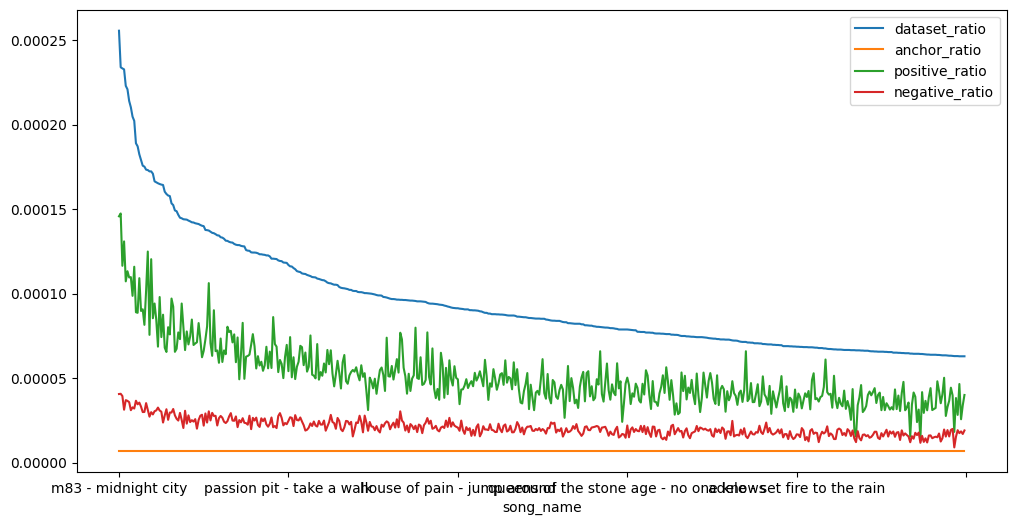

In [ ]:
def check_triplet_balance_ratios_light(df, triplets, top_k=10):
    """
    Check balance of triplets with summary statistics and light visualizations.

    Parameters:
    - df: Original DataFrame with 'unq_playlist_name' and 'song_name'.
    - triplets: List of generated triplets (anchor, positive, negative).
    - top_k: Number of top and bottom songs to display in statistics.

    Returns:
    - None. Prints summary statistics and displays key insights.
    """
    from collections import Counter
    import pandas as pd

    # Extract anchor, positive, and negative songs
    anchors = [triplet[0] for triplet in triplets]
    positives = [triplet[1] for triplet in triplets]
    negatives = [triplet[2] for triplet in triplets]

    # Count occurrences in triplets
    anchor_counts = Counter(anchors)
    positive_counts = Counter(positives)
    negative_counts = Counter(negatives)

    # Count occurrences in the dataset
    dataset_song_counts = df['song_name'].value_counts()

    # Calculate ratios
    song_ratios = pd.DataFrame({
        'song_name': dataset_song_counts.index,
        'dataset_ratio': dataset_song_counts / dataset_song_counts.sum(),
        'anchor_ratio': [anchor_counts[song] / len(anchors) if song in anchor_counts else 0 for song in dataset_song_counts.index],
        'positive_ratio': [positive_counts[song] / len(positives) if song in positive_counts else 0 for song in dataset_song_counts.index],
        'negative_ratio': [negative_counts[song] / len(negatives) if song in negative_counts else 0 for song in dataset_song_counts.index],
    })

    # Summary statistics
    print("Summary Statistics:")
    print(song_ratios.describe())

    # Top-K and Bottom-K Songs
    print("\nTop-K Most Common Anchors:")
    print(song_ratios.nlargest(top_k, 'anchor_ratio')[['song_name', 'anchor_ratio']])

    print("\nTop-K Most Common Positives:")
    print(song_ratios.nlargest(top_k, 'positive_ratio')[['song_name', 'positive_ratio']])

    print("\nTop-K Most Common Negatives:")
    print(song_ratios.nlargest(top_k, 'negative_ratio')[['song_name', 'negative_ratio']])

    print("\nBottom-K Least Common Anchors:")
    print(song_ratios.nsmallest(top_k, 'anchor_ratio')[['song_name', 'anchor_ratio']])

    # Optionally, plot subsampled ratios
    subset_ratios = song_ratios.head(500)  # Limit to top 500 for plotting
    subset_ratios.plot(x='song_name', y=['dataset_ratio', 'anchor_ratio', 'positive_ratio', 'negative_ratio'], kind='line', figsize=(12, 6))

check_triplet_balance_ratios_light(playlists_df, triplets)



# Preparing songs for incorporation in triplets as normalized tensors

In this section song names are converted into normalized numeric vectors using a pre-trained Sentence-BERT model. The embeddings enable the model to learn meaningful relationships between songs by capturing their semantic representations.

## Embedding Song names to numeric vectors using Sentence-BERT pre-trained language model

In [ ]:
# Extract unique songs from triplets

unique_songs = list(set([t[0] for t in triplets] + [t[1] for t in triplets] + [t[2] for t in triplets]))
print(f"Total unique songs: {len(unique_songs)}")


Total unique songs: 1912861


In [ ]:
# Generating Song Embeddings
# Model Used: SentenceTransformer('all-mpnet-base-v2') (a pre-trained Sentence-BERT model).
# Captures contextualized semantic meaning of song names.
# Embedding Process:
# Each unique song is encoded into a high-dimensional vector (embedding) using the BERT model.
# Progress is tracked using tqdm.

from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load pre-trained Sentence-BERT model
model = SentenceTransformer('all-mpnet-base-v2')

# Convert song names to embeddings with progress monitoring
song_embeddings = {}
print("Starting to encode song embeddings...")

for song in tqdm(unique_songs, desc="Encoding songs", unit="song"):
    song_embeddings[song] = model.encode(song)

print(f"Encoding complete. Total songs encoded: {len(song_embeddings)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Starting to encode song embeddings...


Encoding songs: 100%|██████████| 1913703/1913703 [7:28:49<00:00, 71.06song/s]

Encoding complete. Total songs encoded: 1913703


### Saving embeddings file for safe keeping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the file to Google Drive
drive_path = "/content/drive/My Drive/Colab Notebooks/Final Project/song_embeddings.pkl"
with open(drive_path, "wb") as f:
    pickle.dump(song_embeddings, f)

print(f"Normalized embeddings saved to Google Drive at {drive_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normalized embeddings saved to Google Drive at /content/drive/My Drive/Colab Notebooks/Final Project/normalized_embeddings.pkl


### Upload pickle file

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/song_embeddings.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    song_embeddings = pickle.load(f)

print(f"Loaded {len(song_embeddings)} embeddings.")


Mounted at /content/drive
Loaded 1913703 embeddings.


In [ ]:
# Check the number of entries
print(f"Number of songs: {len(song_embeddings)}")

# Inspect the first few entries
for song, embedding in list(song_embeddings.items())[:5]:
    print(f"Song: {song}, Embedding: {embedding[:5]}...")  # Print the first 5 dimensions


Number of songs: 1913703
Song: the new pornographers - champions of red wine, Embedding: [ 0.02234402  0.07678538 -0.00223848 -0.06972852 -0.04036422]...
Song: george frideric handel - suite in b-flat major, hwv 440: ii. courante, Embedding: [-0.03205843 -0.05209947  0.00613783  0.01149455 -0.0289385 ]...
Song: stereo total - push it, Embedding: [-0.01408219  0.02150414  0.01092142 -0.04385082 -0.04616772]...
Song: fabio xb - light to lies - gareth emery mix, Embedding: [-0.02499386 -0.04149881  0.03264454 -0.03759813 -0.05132754]...
Song: go back to the zoo - secret, Embedding: [ 0.07922383  0.06483316 -0.00061289 -0.04684918 -0.03144264]...


## Noralizing embeddings

* Ensure each embedding has unit length, making comparisons based on cosine similarity reliable.
* Process:
Normalize each embedding vector using sklearn.preprocessing.normalize.

In [ ]:
from sklearn.preprocessing import normalize
from tqdm import tqdm

# Normalize embeddings with progress bar
print("Starting normalization of song embeddings...")
for song, embedding in tqdm(song_embeddings.items(), desc="Normalizing embeddings", unit="song"):
    song_embeddings[song] = normalize(embedding.reshape(1, -1))[0]

print("Normalization complete.")


Starting normalization of song embeddings...


Normalizing embeddings: 100%|██████████| 1913703/1913703 [06:47<00:00, 4699.23song/s]

Normalization complete.


In [ ]:
len(next(iter(song_embeddings.values())))

768

In [ ]:
noramlized_embeddings = song_embeddings

## Save normalized embeddings of songs as normalized_embeddings.pkl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Save the file to Google Drive
drive_path = "/content/drive/My Drive/Colab Notebooks/Final Project/normalized_embeddings.pkl"
with open(drive_path, "wb") as f:
    pickle.dump(song_embeddings, f)

print(f"Normalized embeddings saved to Google Drive at {drive_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Normalized embeddings saved to Google Drive at /content/drive/My Drive/Colab Notebooks/Final Project/normalized_embeddings.pkl


In [ ]:
# call normalized_embeddings
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
# Specify the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/normalized_embeddings.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    normalized_embeddings = pickle.load(f)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(f"Loaded {len(normalized_embeddings)} embeddings.")

Loaded 1913703 embeddings.


# Transforming triplets as normalized tensors triplets
This step converts the generated triplets into tensor representations based on normalized song embeddings. The tensors are batched and saved to disk to manage memory efficiently and streamline the training process for the Siamese network.

In [ ]:
import os

def save_triplet_batches_to_disk(triplets, normalized_embeddings, batch_size, save_dir):

    os.makedirs(save_dir, exist_ok=True)

    # Ensure triplets are a list (convert if needed)
    if isinstance(triplets, set):
        triplets = list(triplets)

    num_batches = len(triplets) // batch_size + (len(triplets) % batch_size != 0)

    print("Converting triplets to tensors and saving batches...")
    pbar = tqdm(total=len(triplets), desc="Processing Triplets")

    for batch_idx in range(num_batches):
        batch_start = batch_idx * batch_size
        batch_end = min(batch_start + batch_size, len(triplets))
        batch_triplets = triplets[batch_start:batch_end]

        # Convert triplets to tensors
        batch_data = [
            (
                torch.tensor(normalized_embeddings[anchor], dtype=torch.float),
                torch.tensor(normalized_embeddings[positive], dtype=torch.float),
                torch.tensor(normalized_embeddings[negative], dtype=torch.float),
            )
            for anchor, positive, negative in batch_triplets
        ]

        # Save batch to disk
        batch_file = os.path.join(save_dir, f"batch_{batch_idx}.pt")
        torch.save(batch_data, batch_file)
        pbar.update(len(batch_triplets))

    pbar.close()
    print(f"Saved batches to {save_dir}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

save_dir = "./triplet_batches"
save_triplet_batches_to_disk(triplets, normalized_embeddings, batch_size=200000, save_dir=save_dir)


Converting triplets to tensors and saving batches...


Processing Triplets: 100%|██████████| 14335215/14335215 [1:01:27<00:00, 3887.85it/s]


Saved batches to ./triplet_batches


# Generating Siamese Network Model
This section details the construction, training, and saving of a Siamese Neural Network to learn song embeddings for the recommendation system. The model uses Triplet Loss to optimize the embedding space, ensuring that songs in the same playlist are closer together than unrelated songs.

## Model Architecture - Siamese Network:
* A fully connected neural network with three layers:
** Input layer with dimensionality matching the embeddings (input_dim).
** Hidden layer with ReLU activation (hidden_dim).
** Output layer generating compact embeddings (output_dim).
* Produces embeddings optimized for triplet-based similarity learning

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=32):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.fc(x)


## Loss Function
* Triplet Loss:
** Encourages the anchor-positive distance to be smaller than the anchor-negative distance by a given margin.
** Loss formula: Loss = max(0, distance(anchor, positive) - distance(anchor, negative) + margin)

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive, p=2)  # Euclidean distance
        neg_dist = F.pairwise_distance(anchor, negative, p=2)
        loss = torch.relu(pos_dist - neg_dist + self.margin).mean()
        return loss


In [ ]:
import torch.optim as optim

# Initialize model, loss, and optimizer
input_dim = len(next(iter(normalized_embeddings.values())))  # Dimensionality of your embeddings
model = SiameseNetwork(input_dim)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
)

## Batch Loading
Saved triplets are loaded as tensors from disk in batches, reducing memory consumption.

In [ ]:


import os

def load_batch_from_disk(batch_index, save_dir):
    """
    Loads a single batch from disk.

    Args:
    - batch_index: Index of the batch to load.
    - save_dir: Directory where batches are saved.

    Returns:
    - List of tensors (anchor, positive, negative).
    """
    batch_file = os.path.join(save_dir, f"batch_{batch_index}.pt")
    print(f"Loading batch {batch_index} from {batch_file}...")
    return torch.load(batch_file)


In [ ]:
from torch.utils.data import DataLoader, Dataset

class SingleBatchDataset(Dataset):
    def __init__(self, batch_data):
        """
        Dataset for a single batch of triplets.

        Args:
        - batch_data: List of tensors (anchor, positive, negative).
        """
        self.batch_data = batch_data

    def __len__(self):
        return len(self.batch_data)

    def __getitem__(self, idx):
        return self.batch_data[idx]

# Create a DataLoader for the loaded batch
def create_dataloader(batch_data, batch_size=32):
    dataset = SingleBatchDataset(batch_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Training Loop
Each batch is loaded, processed using a DataLoader, and passed through the network.
The model is trained for multiple epochs on each batch.
Progress Monitoring:
Batch processing is tracked using progress messages.

In [ ]:
def train_on_batch(model, dataloader, optimizer, criterion, device, num_epochs=1):
    """
    Trains the model on a single batch for multiple epochs.

    Args:
    - model: The Siamese network.
    - dataloader: DataLoader for the current batch.
    - optimizer: Optimizer for training.
    - criterion: Loss function (e.g., TripletLoss).
    - device: Device to train on ('cuda' or 'cpu').
    - num_epochs: Number of epochs to train on this batch.

    Returns:
    - Average loss for the last epoch.
    """
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        print(f"Training Epoch {epoch + 1}/{num_epochs}...")

        for anchor, positive, negative in dataloader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            # Compute loss
            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {avg_loss:.4f}")

    return avg_loss



In [ ]:
num_batches = len(os.listdir(save_dir))  # Total number of saved batches

for batch_index in range(num_batches):
    # Step 1: Load the batch
    batch_data = load_batch_from_disk(batch_index, save_dir)

    # Step 2: Create a DataLoader
    dataloader = create_dataloader(batch_data, batch_size=32)

    # Step 3: Train the model on the batch
    batch_loss = train_on_batch(model, dataloader, optimizer, criterion, device, num_epochs=16)
    print(f"Batch {batch_index + 1}/{num_batches}: Loss = {batch_loss:.4f}")


Loading batch 0 from ./triplet_batches/batch_0.pt...


<ipython-input-18-cf5a01c14251>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(batch_file)


Training Epoch 1/16...
Epoch 1/16: Loss = 0.4424
Training Epoch 2/16...
Epoch 2/16: Loss = 0.3611
Training Epoch 3/16...
Epoch 3/16: Loss = 0.3225
Training Epoch 4/16...
Epoch 4/16: Loss = 0.2931
Training Epoch 5/16...
Epoch 5/16: Loss = 0.2699
Training Epoch 6/16...
Epoch 6/16: Loss = 0.2505
Training Epoch 7/16...
Epoch 7/16: Loss = 0.2333
Training Epoch 8/16...
Epoch 8/16: Loss = 0.2180
Training Epoch 9/16...
Epoch 9/16: Loss = 0.2047
Training Epoch 10/16...
Epoch 10/16: Loss = 0.1922
Training Epoch 11/16...
Epoch 11/16: Loss = 0.1820
Training Epoch 12/16...
Epoch 12/16: Loss = 0.1716
Training Epoch 13/16...
Epoch 13/16: Loss = 0.1626
Training Epoch 14/16...
Epoch 14/16: Loss = 0.1541
Training Epoch 15/16...
Epoch 15/16: Loss = 0.1461
Training Epoch 16/16...
Epoch 16/16: Loss = 0.1387
Batch 1/72: Loss = 0.1387
Loading batch 1 from ./triplet_batches/batch_1.pt...
Training Epoch 1/16...
Epoch 1/16: Loss = 0.3951
Training Epoch 2/16...
Epoch 2/16: Loss = 0.3085
Training Epoch 3/16...
Ep

## Saving model

In [ ]:
torch.save(model.state_dict(), "siamese_network.pth")
print("Model saved as siamese_network.pth")


Model saved as siamese_network.pth


In [ ]:
# Define the Google Drive path
drive_path = "/content/drive/My Drive/siamese_network_1.pth"

# Copy the model to Google Drive
!cp siamese_network.pth "$drive_path"
print(f"Model saved to Google Drive at {drive_path}")

Model saved to Google Drive at /content/drive/My Drive/siamese_network_1.pth


# Calling model from drive

In [36]:
# 1. Define the Model Architecture
import torch
import torch.nn as nn

class SiameseNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=32):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.fc(x)

# 2. Instantiate the Model
input_dim = 768  # Example input dimension
model = SiameseNetwork(input_dim)

# 3. Load Weights from Google Drive
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/Colab Notebooks/Final Project/siamese_network_1.pth"

# Load weights into the model
model.load_state_dict(torch.load(drive_path))

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model successfully loaded!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model successfully loaded!


<ipython-input-36-c549e8c0d067>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(drive_path))


# Song Recommendation System Implementation
This section outlines the implementation of the recommendation system. It leverages the Siamese network to transform song embeddings into a meaningful latent space. The system then computes cosine similarity to recommend the most relevant songs based on an input song.

In [37]:
# 1. Transforming Songs into Latent Space
# Function: transform_song
# Purpose:
# Passes a song's precomputed embedding through the trained Siamese network to obtain a transformed embedding.
# The transformed embedding represents the song in the optimized latent space.

def transform_song(song_name, model, song_embeddings):
    model.eval()
    song_embedding = torch.tensor(song_embeddings[song_name], dtype=torch.float).unsqueeze(0).to(device)
    transformed_embedding = model(song_embedding).detach().cpu().numpy()
    return transformed_embedding


In [38]:
# 2. Recommending Songs Using Cosine Similarity
# Function: recommend_songs
# Purpose:
# Recommends songs based on their cosine similarity to the input song in the latent space.
# Computes similarity dynamically by transforming each song's embedding on demand.

from sklearn.metrics.pairwise import cosine_similarity

def recommend_songs(input_song, model, song_embeddings, top_n=5):
    input_embedding = transform_song(input_song, model, song_embeddings)

    # Compute cosine similarity with all songs
    similarities = {
        song: cosine_similarity(input_embedding, transform_song(song, model, song_embeddings))[0][0]
        for song in song_embeddings
    }

    # Sort by similarity and return top-N songs
    recommendations = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommendations


In [ ]:
# 3. Precomputing Transformed Embeddings
# Transforming embeddings on demand can be computationally expensive, especially for large datasets.
# Precomputing all song embeddings after training significantly speeds up the recommendation process.

transformed_embeddings = {
    song: transform_song(song, model, normalized_embeddings)
    for song in normalized_embeddings
}



In [40]:

# 4. Optimized Recommendation with Precomputed Embeddings
# Function: recommend_songs_precomputed
# Purpose:
# Uses precomputed transformed embeddings to calculate cosine similarity, ensuring faster recommendations.
# Removes the input song from the recommendation list.

def recommend_songs_precomputed(input_song, transformed_embeddings, top_n=5):

    input_embedding = transformed_embeddings[input_song]

    # Compute cosine similarity with all songs
    similarities = {
        song: cosine_similarity(input_embedding, transformed_embeddings[song])[0][0]
        for song in transformed_embeddings
    }

    # Remove the input song from the results
    if input_song in similarities:
        del similarities[input_song]  # Explicitly remove input song

    # Sort by similarity and return top-N songs
    recommendations = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommendations


In [ ]:
# Saving Transformed Embeddings to avoid recomputation during runtime resets.

from google.colab import drive
drive.mount('/content/drive')

# Save the file to Google Drive
drive_path = "/content/drive/My Drive/Colab Notebooks/Final Project/transformed_embeddings.pkl"
with open(drive_path, "wb") as f:
    pickle.dump(transformed_embeddings, f)

print(f"Transformed embeddings saved to Google Drive at {drive_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Transformed embeddings saved to Google Drive at /content/drive/My Drive/Colab Notebooks/Final Project/transformed_embeddings.pkl


In [ ]:
input_song = "elton john - your song"
top_recommendations = recommend_songs_precomputed(input_song, transformed_embeddings, top_n=5)
print(f"Top recommendations for '{input_song}':")
for song, score in top_recommendations:
    print(f"{song}: {score:.4f}")


Top recommendations for 'elton john - your song':
elton john - madness: 0.9508
elton john - lovesick: 0.9498
elton john - you gotta love someone: 0.9492
elton john - your song - live: 0.9484
elton john - elton john - your song: 0.9462


In [41]:
# playlist generator with visualization

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

def recommend_songs_precomputed_with_progress(input_song, transformed_embeddings, top_n=5):

    if input_song not in transformed_embeddings:
        raise ValueError(f"The input song '{input_song}' does not exist in the transformed embeddings.")

    input_embedding = transformed_embeddings[input_song]

    # Compute cosine similarity with all songs
    similarities = {}
    print(f"Calculating similarities for input song: '{input_song}'")
    for song in tqdm(transformed_embeddings.keys(), desc="Computing similarities", unit="song"):
        if song != input_song:  # Exclude the input song from recommendations
            similarities[song] = cosine_similarity(input_embedding, transformed_embeddings[song])[0][0]

    # Sort by similarity and return top-N songs
    recommendations = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return recommendations


# Usage Example
input_song = "sia - the girl you lost to cocaine"
top_recommendations = recommend_songs_precomputed_with_progress(input_song, transformed_embeddings, top_n=5)

print(f"\nTop recommendations for '{input_song}':")
for song, score in top_recommendations:
    print(f"{song}: {score:.4f}")


Calculating similarities for input song: 'sia - the girl you lost to cocaine'


Computing similarities: 100%|██████████| 1913703/1913703 [14:00<00:00, 2277.12song/s]



Top recommendations for 'sia - the girl you lost to cocaine':
sia - the girl you lost to cocaine - mark pichiotti edit: 0.8935
sia - the girl you lost to cocaine (stonebridge edit): 0.8832
sia - the girl you lost to cocaine (stonebridge radio edit): 0.8734
kanye west - never let me down: 0.8723
the ink spots - money honey: 0.8652


In [33]:
# call files back to set - mount drive (1)

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# call transformed_embeddings
import pickle

file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/transformed_embeddings.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    transformed_embeddings = pickle.load(f)



# Validation of the Recommendation Model
This section outlines the validation process for the recommendation model. Using precomputed embeddings and test playlists, the model is evaluated for its ability to recommend relevant songs based on user playlists. Key metrics such as Precision@K, Recall@K, and Mean Average Precision (MAP) are used to quantify performance.

## Generating test data

In [66]:
playlist_song_counts = test_data.groupby("unq_playlist_name")["song_name"].count()

# Filter playlists with at least `min_songs`
valid_playlists = playlist_song_counts[playlist_song_counts >= 3].index

# Filter the original DataFrame to keep only the valid playlists
test_data = test_data[test_data["unq_playlist_name"].isin(valid_playlists)]

In [75]:
test_data.shape

(1831034, 7)

In [76]:
len(test_data['unq_playlist_name'].unique())

134740

In [77]:
import random

def sample_playlists_for_validation(test_data, num_samples=100, seed=42):
    """
    Sample playlists from the test dataset for validation.

    Args:
    - test_data (pd.DataFrame): Test data containing playlists.
    - num_samples (int): Number of playlists to sample.
    - seed (int): Random seed for reproducibility.

    Returns:
    - validation_playlists: Sampled playlists.
    """
    random.seed(seed)

    # Group playlists
    playlists = test_data['unq_playlist_name'].unique()

    # Determine number of samples
    num_samples = min(len(playlists), num_samples)
    sampled_playlists = random.sample(list(playlists), num_samples)

    # Filter test data for sampled playlists
    validation_playlists = test_data[test_data['unq_playlist_name'].isin(sampled_playlists)]
    return validation_playlists


# Example Usage
# Assume test_data is a DataFrame with 'unq_playlist_name' and 'song_name'
validation_data = sample_playlists_for_validation(test_data, num_samples=500)

# Determine "k"
average_playlist_length = test_data.groupby('unq_playlist_name')['song_name'].count().mean()
k = min(10, int(average_playlist_length))  # Use 10 or the average playlist length, whichever is smaller

print(f"Validation Data Playlists to sample: {len(validation_data['unq_playlist_name'].unique())}")
print(f"Recommended k for Precision@K and Recall@K: {k}")


Validation Data Playlists to sample: 500
Recommended k for Precision@K and Recall@K: 10


In [69]:
import pandas as pd

def create_test_playlists(test_data):

    # Group songs by unique playlist name
    test_playlists = (
        test_data.groupby('unq_playlist_name')['song_name']
        .apply(list)
        .to_dict()
    )
    return test_playlists

test_playlists = create_test_playlists(test_data)

# Display the test playlists
# for playlist, songs in test_playlists.items():
#     print(f"{playlist}: {songs}")


In [70]:
len(test_playlists)

134740

In [71]:
def prepare_validation_data(test_playlists, all_songs, num_playlists=5, seed=42):
    """
    Prepares validation data by sampling playlists and creating positive and candidate song sets.

    Args:
    - test_playlists: Dictionary of playlist_id -> list of songs in the playlist.
    - all_songs: Set of all unique songs in the dataset.
    - num_playlists: Number of playlists to sample for validation.
    - seed: Random seed for reproducibility.

    Returns:
    - validation_data: List of (playlist_id, positive_songs, candidate_songs).
    """
    random.seed(seed)

    # Randomly sample playlists
    selected_playlists = random.sample(list(test_playlists.items()), num_playlists)

    validation_data = []
    for playlist_id, songs in selected_playlists:
        positive_songs = set(songs)  # Songs in the playlist
        candidate_songs = all_songs  # All songs, including positive ones, as candidates
        validation_data.append((playlist_id, positive_songs, candidate_songs))

    return validation_data


all_songs = set(song for songs in test_playlists.values() for song in songs)

validation_data = prepare_validation_data(test_playlists, all_songs)


## Calling transformed embeddings of all songs

In [ ]:
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Specify the file path in Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Final Project/transformed_embeddings.pkl'

# Load the pickle file
with open(file_path, 'rb') as f:
    normalized_embeddings = pickle.load(f)

print(f"Loaded {len(transformed_embeddings)} embeddings.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 1913703 embeddings.


## Validation of the Siamese Model with Precision@K, Recall@K, and MAP

* Cosine similarity is used to rank candidate songs.
* Metrics are calculated:
** Precision@K: Fraction of top-K recommended songs in the playlist.
** Recall@K: Fraction of playlist songs captured in the top-K recommendations.
** MAP: Evaluates the ranking order of playlist songs in the recommendations.


In [72]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Function to compute playlist probabilities
def compute_playlist_probabilities(playlist_id, positive_songs, candidate_songs, transformed_embeddings):
    """
    Compute the cosine similarity scores between the input song and all candidate songs.

    Args:
    - playlist_id: Unique ID for the playlist.
    - positive_songs: Set of songs in the playlist.
    - candidate_songs: Set of songs not in the playlist.
    - transformed_embeddings: Precomputed transformed embeddings for all songs.

    Returns:
    - scores: Dictionary of candidate song -> average similarity score.
    """
    positive_embeddings = np.stack(
        [transformed_embeddings[song].reshape(-1) for song in positive_songs]
    )  # Shape: (num_positive_songs, embedding_dim)

    scores = {}
    for candidate in candidate_songs:
        candidate_embedding = transformed_embeddings[candidate].reshape(1, -1)  # Shape: (1, embedding_dim)
        similarity = cosine_similarity(candidate_embedding, positive_embeddings)  # Shape: (1, num_positive_songs)
        scores[candidate] = similarity.mean()  # Average similarity to all positive songs

    return scores


# Function to evaluate ranking metrics
def evaluate_ranking(scores, positive_songs, top_k=10):
    """
    Evaluate Precision@K, Recall@K, and Mean Average Precision (MAP).

    Args:
    - scores: Dictionary of song -> similarity score.
    - positive_songs: Set of songs in the playlist.
    - top_k: Number of top recommendations to consider.

    Returns:
    - precision: Precision@K score.
    - recall: Recall@K score.
    - map_score: Mean Average Precision score.
    """
    # Sort candidates by descending scores
    ranked_songs = sorted(scores.keys(), key=lambda x: scores[x], reverse=True)

    # Compute Precision@K
    top_k_songs = ranked_songs[:top_k]
    true_positives = len(set(top_k_songs) & positive_songs)
    precision = true_positives / top_k

    # Compute Recall@K
    recall = true_positives / len(positive_songs)

    # Compute Mean Average Precision (MAP)
    average_precision = 0
    num_hits = 0
    for i, song in enumerate(ranked_songs):
        if song in positive_songs:
            num_hits += 1
            average_precision += num_hits / (i + 1)
    map_score = average_precision / len(positive_songs)

    return precision, recall, map_score


# Validate the model
def validate_model(validation_data, transformed_embeddings, top_k=10):
    """
    Validate the model on the test data and compute average Precision@K, Recall@K, and MAP.

    Args:
    - validation_data: List of (playlist_id, positive_songs, candidate_songs).
    - transformed_embeddings: Precomputed transformed embeddings for all songs.
    - top_k: Number of top recommendations to consider.

    Returns:
    - avg_metrics: Dictionary with average Precision@K, Recall@K, and MAP.
    """
    all_metrics = {"precision": [], "recall": [], "map": []}

    print("\nValidating model on test data...")
    for playlist_id, positive_songs, candidate_songs in tqdm(validation_data, desc="Processing Playlists", unit="playlist"):
        # Compute similarity scores
        scores = compute_playlist_probabilities(playlist_id, positive_songs, candidate_songs, transformed_embeddings)

        # Evaluate ranking metrics
        precision, recall, map_score = evaluate_ranking(scores, positive_songs, top_k=top_k)

        # Store metrics
        all_metrics["precision"].append(precision)
        all_metrics["recall"].append(recall)
        all_metrics["map"].append(map_score)

        print(f"Playlist: {playlist_id} - Precision@{top_k}: {precision:.4f}, Recall@{top_k}: {recall:.4f}, MAP: {map_score:.4f}")

    # Compute averages across all playlists
    avg_metrics = {metric: np.mean(values) for metric, values in all_metrics.items()}

    print("\nOverall Validation Metrics:")
    print(f"Average Precision@{top_k}: {avg_metrics['precision']:.4f}")
    print(f"Average Recall@{top_k}: {avg_metrics['recall']:.4f}")
    print(f"Average MAP: {avg_metrics['map']:.4f}")

    return avg_metrics


# Run validation with progress bar
top_k = 10  # Define the value of K
results = validate_model(validation_data, transformed_embeddings, top_k=top_k)

# Results will contain average metrics
print(f"\nFinal Results - Precision@{top_k}: {results['precision']:.4f}, Recall@{top_k}: {results['recall']:.4f}, MAP: {results['map']:.4f}")



Validating model on test data...


Processing Playlists:  20%|██        | 1/5 [06:27<25:51, 387.83s/playlist]

Playlist: 3747f062ed02c850263be42867df3fc1 - heart - Precision@10: 0.1000, Recall@10: 0.3333, MAP: 0.1926


Processing Playlists:  40%|████      | 2/5 [12:30<18:38, 372.84s/playlist]

Playlist: 0ca1ce8dfb521551599c3880008c767d - codeshow - Precision@10: 0.0000, Recall@10: 0.0000, MAP: 0.0001


Processing Playlists:  60%|██████    | 3/5 [18:58<12:39, 379.86s/playlist]

Playlist: 87bc8afb3f127d785ec34861b4560b21 - j. givens - el v. envy - Precision@10: 0.1000, Recall@10: 0.2500, MAP: 0.1534


Processing Playlists:  80%|████████  | 4/5 [25:25<06:22, 382.69s/playlist]

Playlist: 7815b098ed3390178af2adb9b4ee5546 - delta rae - after it all - Precision@10: 0.3000, Recall@10: 0.6000, MAP: 0.3524


Processing Playlists: 100%|██████████| 5/5 [31:26<00:00, 377.20s/playlist]

Playlist: 6d7ce2f21d3f5f422e39bdb98cdf85fe - country - Precision@10: 0.0000, Recall@10: 0.0000, MAP: 0.0061

Overall Validation Metrics:
Average Precision@10: 0.1000
Average Recall@10: 0.2367
Average MAP: 0.1409

Final Results - Precision@10: 0.1000, Recall@10: 0.2367, MAP: 0.1409
